In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('glass.csv')
df_pure = df
df.shape

(214, 10)

In [3]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


# 1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

Данный набор состоит из 214 типов стекла. 10 показателей для описания различных видов стекла:
    RI - Показатель преломления
    Аттрибуты 2-9 определяют какой процент от массы стекла составляют определенные оксиды:
        Na - Натрий
        Mg - Магний
        Al - Алюминий
        Si - Кремний
        K - Калий
        Ca - Кальций
        Ba - Барий
        Fe - Железо
    
    Атрибут 10 показывает тип стекла (возможны 7 видов):
        1 - Строительное окно с обработкой
        2 - Строительное окно без обработки
        3 - Автомобильное окно с обработкой
        4 - Автомобильное окно без обработки (отсутствуют в таблице)
        5 - Контейнеры
        6 - Посуда
        7 - Источник света (фонарь, фара...)

# 2. Удалите дубликаты строк в наборе данных

In [4]:
df = df.drop_duplicates()
df = df.dropna()
df.shape

(213, 10)

# 3. Оцените сбалансированность данных по классам (постройте гистограмму)

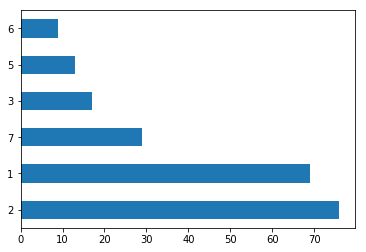

In [5]:
%matplotlib inline
df['Type'].value_counts().plot.barh()
plt.show()

# 4. Выполните масштабирование количественных признаков

In [6]:
df['Type'] = df['Type'].apply(lambda x: str(x))

numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('Числовые столбцы: ', numerical_columns)
print('Столбцы категорий: ', categorial_columns)

Числовые столбцы:  ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
Столбцы категорий:  ['Type']


In [7]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.432836,0.437594,1.000000,0.252336,0.351786,0.009662,0.308550,0.0,0.0,1
1,0.283582,0.475188,0.801782,0.333333,0.521429,0.077295,0.223048,0.0,0.0,1
2,0.220808,0.421053,0.790646,0.389408,0.567857,0.062802,0.218401,0.0,0.0,1
3,0.285777,0.372932,0.821826,0.311526,0.500000,0.091787,0.259294,0.0,0.0,1
4,0.275241,0.381955,0.806236,0.295950,0.583929,0.088567,0.245353,0.0,0.0,1


# 5. Выполните замену категориальных признаков

In [8]:
for i in categorial_columns:
    print(i,': ', df[i].unique())

Type :  ['1' '2' '3' '5' '6' '7']


In [9]:
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(213, 15)


,Type_1,Type_2,Type_3,Type_5,Type_6,Type_7,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1,0,0,0,0,0,0.432836,0.437594,1.000000,0.252336,0.351786,0.009662,0.308550,0.0,0.0
1,1,0,0,0,0,0,0.283582,0.475188,0.801782,0.333333,0.521429,0.077295,0.223048,0.0,0.0
2,1,0,0,0,0,0,0.220808,0.421053,0.790646,0.389408,0.567857,0.062802,0.218401,0.0,0.0
3,1,0,0,0,0,0,0.285777,0.372932,0.821826,0.311526,0.500000,0.091787,0.259294,0.0,0.0
4,1,0,0,0,0,0,0.275241,0.381955,0.806236,0.295950,0.583929,0.088567,0.245353,0.0,0.0


# 6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

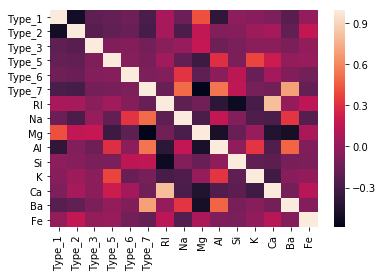

In [10]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

# 7. Заполните пропущенные значения в данных

Пропущенных значений нет

# 8. Решите поставленную задачу классификации в соответствии с заданием

In [11]:
# разделим полученные данные на данные для обучения и теста
X, y = df_pure.drop('Type', axis=1), df_pure['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(149, 9)
(65, 9)


In [12]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 2, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, ' at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.5704697986577181  at radius: 1.8
test score:  0.584615384615


In [13]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,10)), 'max_features': list(range(1,10))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.6845637583892618 	 at features number: 6 	 at depth: 4
test score:  0.646153846154


In [14]:
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

In [15]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),7), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1, 2, 3, 4, 5, 6]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

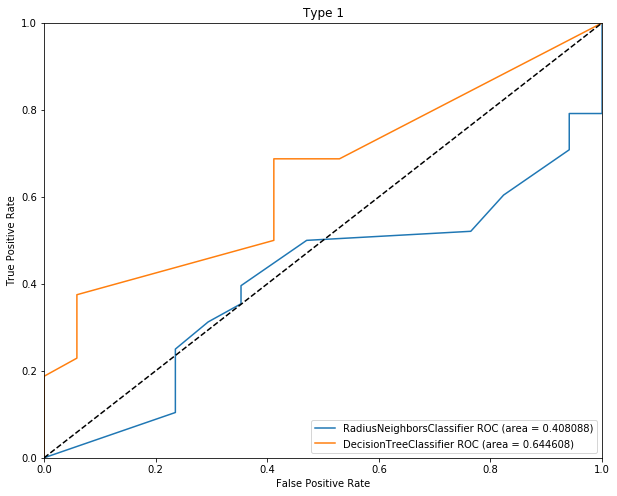

In [16]:
# ROC
plt.figure(figsize=(10,8))
mrnc = MyRadiusNeighborsClassifier(outlier_label=7, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Type 1')
plt.show()

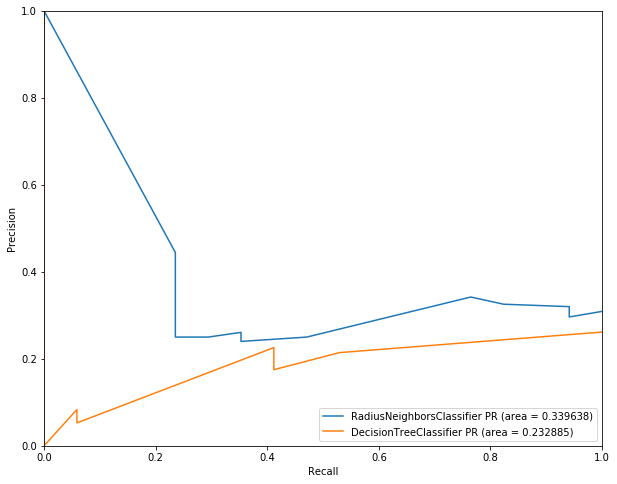

In [17]:
# PR
plt.figure(figsize=(10,8))
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test[:,1],probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 

precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test[:,1],probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

# 9. Сравните кривые для классификаторов, указанных в задании, сделайте вывод

Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели качества относительно ROC кривой. В целом, данные классификаторы слабо решают задачу предсказания класса с вероятностью ~0.45-0.6, но и лучше от случайного - 0.17 (т.к. классов всего 6). Поэтому задача классификации была решена, но по-прежнему есть пути улучшить результаты: подобрать более подходящий под задачу классификатор, осуществить несколько иной подход к подготовке данных в соответсвие с выбранным классификатором.